# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


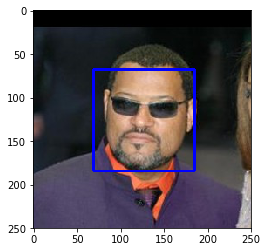

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

The percentage of the first 100 images in human_files have a detected human face is:
99%

The percentage of the first 100 images in dog_files have a detected human face is:
11%



In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_detected_In_humans_imgs_percent = len(np.where(np.array([face_detector(next_image) for next_image in human_files_short]))[0]) / len(human_files_short) * 100
human_detected_In_dogs_imgs_percent = len(np.where(np.array([face_detector(next_image) for next_image in dog_files_short]))[0]) / len(dog_files_short) * 100

print("The percentage of the first 100 images in human_files have a detected human face: {}%".format(human_detected_In_humans_imgs_percent))
#99.0%
print("The percentage of the first 100 images in dog_files have a detected human face: {}%".format(human_detected_In_dogs_imgs_percent))
#11.0%

The percentage of the first 100 images in human_files have a detected human face: 99.0%
The percentage of the first 100 images in dog_files have a detected human face: 11.0%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Reasonable expectation really depend on where this algorithm is applied to.
For example, 
  - if this algorithm to be use for passport / ID photos, i think it is a good job the algorithm rejects photos with an unclear view, standard ID photos are always clear and front view.
  - if this algorithm to be use in social media features, e.g. face tagging, then the content in the photo likely to contains other objects like friends, food, pet etc.
    The faces are common to be on side view or at an angle in social media.
To detect humans in images without a clearly presented face, my suggestion is to train the CNN model with side view of people faces, on top of the front view, 
also with different face expressions like smile, angry etc, and lighter / darker photos. 
Also, have an algorithm to detect noises and remove them before training.





We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

# i have attempted to build A CNN for face detection, but never finished.
# My plan was:
# run OpenCV on dataset human_files, extract the detected face portion as new image files.
# train a new CNN on extracted face images from OpenCV (Y Face=True)
# train the CNN on CIFAR 10/100 for non face images (Y Face=False)
# tweak hyper-parameters and epochs to try to get a better accuracy than OpenCV (maybe impossible)
# A problem i had is training on the same CNN on different size of images.
# the face images has only the face, but all other images have other elements in the image.
# resize both face and non face images to same dimension like 64x64 certainly will not work.
# as the details of a large image with objects in a small scale, shrinking will lose too much details.
# i wan't able to finish my analysis due to my time available for this project.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

The percentage of the images in human_files_short have a detected dog is:
1%

The percentage of the images in dog_files_short have a detected dog is:
100%



In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detected_In_humans_imgs_percent = len(np.where(np.array([dog_detector(next_image) for next_image in human_files_short]))[0]) / len(human_files_short) * 100
dog_detected_In_dogs_imgs_percent = len(np.where(np.array([dog_detector(next_image) for next_image in dog_files_short]))[0]) / len(dog_files_short) * 100

print("The percentage of the images in human_files_short have a detected dog: {}%".format(dog_detected_In_humans_imgs_percent))
print("The percentage of the images in dog_files_short have a detected dog: {}%".format(dog_detected_In_dogs_imgs_percent))


The percentage of the images in human_files_short have a detected dog: 1.0%
The percentage of the images in dog_files_short have a detected dog: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

# If you exit / shutdown the environment, and best weights are saved
# You do not need to run train_tensors and valid_tensors, which takes up about 3-4GB RAM

# train_tensors[0].shape
#(224, 224, 3) # input shape

100%|██████████| 836/836 [00:16<00:00, 62.90it/s]


In [10]:
# Due to Memory Error or Kernel crashes often in my environment
# (12Gb RAM isn't enough to run project from start to finish)
# I have cut out part of code to run seperately once CNN is trained.
# as some code are no longer needed once the CNN is trained and the best weight saved.
# only test_tensors is needed for later use in the project 
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 836/836 [00:22<00:00, 36.99it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I have used the hinted architecture.

The hinted architecture have 3 layers of conv nets, which i checked its similar to an example online CNN Image recognition.
An example of keras CNN - with 32, 64 filters in 2 Conv2d layers
  https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py

In the hinted architecture:  
The first conv2D layer should pick up horizontal and vertical lines
The second conv2D layer should pick up the shapes, complex lines
The third conv2D layer should pick up the eyes, nose, mouth etc

kernel size of 2 will pick up the smallest details.
padding 'same' will lose no details on the image edges.
filters (neurons) are set to 16, 32, and 64, the filters double each time, which i assume because each layer requires more neurons to hold the informations than the last layer.

pooling 
  reduces the 'white spaces' and noises, and only keep the most important information/detail
  also reduces the size of the image/kernel/matrix
 
The output layer have 133 units/probabilties, which represent the 133 dog breeds

But the dropout layer is not listed on the hinted architecture (I am not sure why). Therefore i did not implemenet Dropout in code.


In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [12]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [14]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 149s - loss: 4.8847 - acc: 0.0096 - val_loss: 4.8676 - val_acc: 0.0132
Epoch 2/5
6680/6680 [==============================] - 158s - loss: 4.8620 - acc: 0.0132 - val_loss: 4.8479 - val_acc: 0.0180
Epoch 3/5
6680/6680 [==============================] - 152s - loss: 4.8185 - acc: 0.0181 - val_loss: 4.8086 - val_acc: 0.0251
Epoch 4/5
6680/6680 [==============================] - 152s - loss: 4.7830 - acc: 0.0168 - val_loss: 4.7944 - val_acc: 0.0180
Epoch 5/5
6680/6680 [==============================] - 159s - loss: 4.7574 - acc: 0.0196 - val_loss: 4.7753 - val_acc: 0.0240


### Load the Model with the Best Validation Loss

In [13]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [14]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.9139%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 12.7801 - acc: 0.1102 - val_loss: 11.5301 - val_acc: 0.1641
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.9346 - acc: 0.2370 - val_loss: 10.7732 - val_acc: 0.2467
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.4274 - acc: 0.2964 - val_loss: 10.6197 - val_acc: 0.2551
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 10.2409 - acc: 0.3265 - val_loss: 10.5116 - val_acc: 0.2814
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 10.1273 - acc: 0.3437 - val_loss: 10.4384 - val_acc: 0.2874
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 10.0045 - acc: 0.3552 - val_loss: 10.3552 - val_acc: 0.2898
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.9539 - acc: 0.3663 - val_loss: 10.4377 - val_acc: 0.2946
Epoch 8/20
6680/6680 [==============================] - 1s - loss

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get best index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# get number of matches between predicted and test, calculate accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)

# report test accuracy
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 37.4402%


### Predict Dog Breed with the Model

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [15]:
### TODO: Obtain bottleneck features from another pre-trained CNN.

#bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz') # 811MB
#bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz') # 077MB
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz') # 1.6GB
#Due to memory errors, i have avoid using the largest dataset 'Xception', which is 3GB+

#checker_path = 'saved_models/weights.best.VGG19.hdf5'
#checker_path = 'saved_models/weights.best.Resnet50.hdf5'
checker_path_network = 'saved_models/weights.best.InceptionV3.hdf5'


In [ ]:
# run this code cell if CNN is not yet trained
train_network = bottleneck_features['train']
valid_network = bottleneck_features['valid']
test_network = bottleneck_features['test']

# train_network.shape[1:] 
#(5, 5, 2048) # input shape

In [16]:
### once CNN is trained, next time run only part of the code, to save memory. 
test_network = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


I have experimented with 3 of the 4 datasets:

VGG19 - 811MB

Resnet50 - 077MB

InceptionV3 - 1.6GB

I have not use Xception as the dataset size is over 3GB, loading this dataset will all the previous code in memory could cause memory error as i have experienced before.

InceptionV3 had the best accuracy score of the 3 dataset i used, so i decided to submit the code with that dataset.

Steps 
I have assigned variables to the train, valid and test in the bottleneck_features, the npz dataset.

I have created a file path for the checkpoint to save the best weights during model training

I have followed Step 4 CNN architecture, using just one Average Pooling layer, and an output layer with 133 units, with activation 'softmax', see model summary

The model compile method used the exact same parameters as in Step 4, it just works.
  optimizer = rmsprop'
  loss = categorical_crossentropy'
  metrics=accuracy

I have initially train the model with 100 epochs, during experimenting, but i have noticed the model stop improving after about 10 epochs.
Since the checkpoint have saved the best weights, i do not need to change the epochs and re-train the model again.
The saved best weights are loaded back into the model.
 
Then i have used the predict method on test data 'test_network' from InceptionV3 to get the output labels.

To check the model accuracy, i have compare the predicted label to the real test label.

The accuracy score is over 80%, which is above the required 60%

The accuracy score have proven the model architecture is suitable for the current problem.  
  



In [17]:
### TODO: Define your architecture.

network_model = Sequential()

network_model.add(GlobalAveragePooling2D(input_shape=(5, 5, 2048)))

network_model.add(Dense(133, activation='softmax'))

network_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [18]:
### TODO: Compile the model.

network_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
### TODO: Train the model.

checkerpoint_network = ModelCheckpoint(checker_path_network, save_best_only=True, verbose=1)

epochs = 10

network_model.fit(train_network, train_targets,
                validation_data=(valid_network, valid_targets),
                epochs=epochs, batch_size=20, verbose=1,
                callbacks=[checkerpoint_network])


Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 102s - loss: 1.1575 - acc: 0.7039 - val_loss: 0.7032 - val_acc: 0.8132
Epoch 2/10
6680/6680 [==============================] - 4s - loss: 0.4710 - acc: 0.8566 - val_loss: 0.6757 - val_acc: 0.8251
Epoch 3/10
6680/6680 [==============================] - 3s - loss: 0.3574 - acc: 0.8855 - val_loss: 0.6766 - val_acc: 0.8371
Epoch 4/10
6680/6680 [==============================] - 3s - loss: 0.2948 - acc: 0.9052 - val_loss: 0.6607 - val_acc: 0.8503
Epoch 5/10
6680/6680 [==============================] - 3s - loss: 0.2377 - acc: 0.9259 - val_loss: 0.6783 - val_acc: 0.8539
Epoch 6/10
6680/6680 [==============================] - 3s - loss: 0.2037 - acc: 0.9373 - val_loss: 0.7203 - val_acc: 0.8299
Epoch 7/10
6680/6680 [==============================] - 3s - loss: 0.1689 - acc: 0.9449 - val_loss: 0.7370 - val_acc: 0.8443
Epoch 8/10
6680/6680 [==============================] - 3s - loss: 0.1417 - 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [19]:
### TODO: Load the model weights with the best validation loss.

network_model.load_weights(checker_path_network)


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [20]:
### TODO: Calculate classification accuracy on the test dataset.

#predicted
network_prediction_probabilities = network_model.predict(test_network, batch_size=32, verbose=0)
network_predict_labels = [np.argmax(p) for p in network_prediction_probabilities]
network_predict_labels = np.array(network_predict_labels)

#test data
test_labels = [np.argmax(test_targets, axis=1)]

# calculation
predict_match_test_count = np.sum(network_predict_labels == test_labels)
network_accuracy = 100 * (predict_match_test_count / len(network_predict_labels))

# print result
print('Network test accuracy: %.4f%%' % network_accuracy)

Network test accuracy: 81.3397%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [28]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from keras.preprocessing import image
from extract_bottleneck_features import *

def network_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
        
    # obtain predicted vector
    predicted_vector = network_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


In [ ]:
### Notice: about 100MB RAM is used each call to this method
### and the memory is not free after execution
### eventually I will either get a memory error and kernel restart itself
### or the environment hang and a manual computer restart is required
### in my case it is Linux Ubuntu on VMware player


In [44]:
### ***DEBUG Memory - DO NOT RUN THIS as part of project***

### Here i was trying to debug memory leaks
### create model and reuse, rather than create one for each prediction
### ref extract_bottleneck_features.py
### in the original code, each prediction uses about 100MB RAM and memory not free after execution
### In this version, memory is free after use, confirmed by checking system monitor
### but the predict results is about 30% less accurate than the original, i don't know why

# from keras.applications.inception_v3 import InceptionV3, preprocess_input
# def extract_InceptionV3_ImageNet_Model():
#     return InceptionV3(weights='imagenet', include_top=False)

# model_InceptionV3 = extract_InceptionV3_ImageNet_Model() # reuse model

# def network_predict_breed(img_path):
#     # extract bottleneck features    
#     bottleneck_feature = model_InceptionV3.predict(preprocess_input(path_to_tensor(img_path)))
#     
#     # obtain predicted vector
#     predicted_vector = network_model.predict(bottleneck_feature)
#     # return dog breed that is predicted by the model
#     return dog_names[np.argmax(predicted_vector)]


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [24]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

import os.path

# detect if the image is a human or dog, and which dog breed look alike
def detect(img_path):
    
    animal = '' # human, dog, neither
    dog_breed = '' # dog breed name
    
    # checks
    if(os.path.exists(img_path) == False):
        raise(FileNotFoundError('Image file not found'))    
    
    is_human = face_detector(img_path)
    
    if(is_human == True):
        animal = 'human'
        dog_breed_look_like = network_predict_breed(img_path)
        dog_breed = dog_breed_look_like
    else:
        is_dog = dog_detector(img_path)
        if(is_dog == True):
            animal = 'dog'
            dog_breed_look_like = network_predict_breed(img_path)
            dog_breed = dog_breed_look_like
        else:
            animal = 'neither'

    return (animal, dog_breed)


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Notice: I do not have any good photos so i have googled all the test images.

Q. Is the output better than you expected :) ? Or worse :( ? 

I have used 20 images for testing, each correct prediction add 5% to the accuracy

Step 1 - face detector with opencv accuracy is 99%

Step 5 - dog breed accuracy score is 81% 

So i made a quick assumption that Step 7 will get about 90% accuracy score.

In testing results:

One case failed both human face detection + dog breed detection = -5%
(Image: jolin-tsai.jpg)

One case a dog mistaken to be a human, but got the dog breed right = -2.5%
(Image: cairn_terrier.jpg)

Step 7 test accuracy is 92.5% 

100% - 5% - 2.5% = 92.5% 

(This is just a made up calculation, no real math formula used in here!)

The result is a little better than i was expected.
  
  
Q. Provide at least three possible points of improvement for your algorithm.

1. Better face detection (optional task)
I did not have time or skill to complete the optional task, but with better face detection the accuracy surely will increase.

2. Augmented image may give a better dog breed detection (optional task)
CNN with Augmented image do take a much longer time to train, i have executed code in lesson 20 - Image Augmentation in Kera. and I have noticed the increase in accuracy.

3. CNN model parameters
  adjust number of Conv2D layers, 
  tuning hyperparameters of the CNN model, 
  increase number epochs,
  Dropout - try different dropout rate,
  use a different larger dataset for dog breed, e.g. Xception.npz



In [25]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

import time # time was used to analysis how much time the test has taken
import ntpath
# import gc # garbage collector was used to try tackle memory error, but did not helped

# load test images found by google
step7_test_imgs = np.array(glob('testImages/*'))
print (step7_test_imgs)


['testImages/albert einstein.jpg' 'testImages/basset-hound.jpg'
 'testImages/bill gate.jpg' 'testImages/bruce-lee.jpg'
 'testImages/cairn_terrier.jpg' 'testImages/cat.jpeg'
 'testImages/Chinese_shar-pei.jpg' 'testImages/Demis Hassabis.jpg'
 'testImages/donnie-yen.png' 'testImages/elon_musk.jpg'
 'testImages/gem.jpg' 'testImages/Golden_retriever.jpg'
 'testImages/jackie-chan.png' 'testImages/Japanese_chin.jpg'
 'testImages/jolin-tsai.jpg' 'testImages/Kuvasz.png' 'testImages/lion.jpg'
 'testImages/simpsons.jpg' 'testImages/Stephan-Hawking.jpg'
 'testImages/wu-jing.jpg']


In [26]:
### save test result methods to review later without a complete test re-run

# save test result method
def save(array, file_path):
    # save an array of data
    np.savetxt(file_path, array, delimiter=',', fmt='%s')

# load test result method
def load(file_path):
    # load data back to an array
    load_file = open(file_path, 'r') # open file
    lines = load_file.readlines() # load raw data
    array = [n.rstrip() for n in lines] # remove new line char '\n'
    return array

In [29]:
### run test, time how much time it took

# timer start
start_time = time.time()

test_results = []
for filename in step7_test_imgs:
    result = detect(filename)
    test_results.append([result, ntpath.basename(filename)])
    #gc.collect() # not helped on memeory error
    
stop_time = time.time()

print ('time taken to execute test in seconds:', (stop_time - start_time))

time taken to execute test in seconds: 278.7792730331421


In [30]:
### save result for next time load without running test again

# save result 1st time
save(test_results, 'step7_test_result.txt')

# load result, on 2nd time visit
load_test_results = load('step7_test_result.txt')

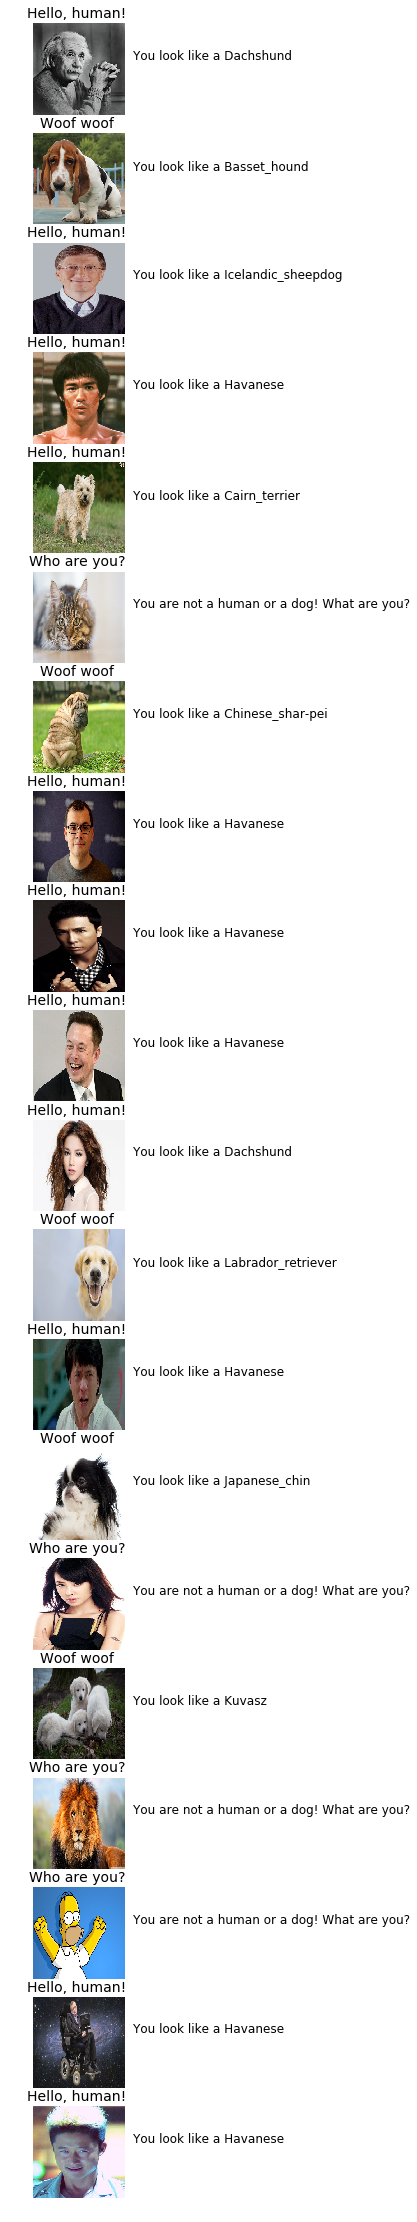

In [43]:
### visualize the 20 test images results

from keras.preprocessing.image import load_img

# reimport libraries if kernel close down and come back to run the result in display only
import math
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(40, 40))

human_greeting = 'Hello, human! '
dog_greeting = 'Woof woof ' 
neither_greeting = 'Who are you? '
dog_breed_message_prefix = 'You look like a '
dog_breed_no_match_message = 'You are not a human or a dog! What are you?'

display_columns = 1.
display_rows = math.ceil(len(load_test_results) / display_columns)

for i in range(len(load_test_results)):
    ax = fig.add_subplot(display_rows, display_columns, i+1)

    test_row_info = load_test_results[i].split(',')
    
    # assign info into variables, and strip out unwanted string in data
    animal = test_row_info[0].lstrip().rstrip().replace('(', '').replace(')', '').replace("'", '')
    dog_breed = test_row_info[1].lstrip().rstrip().replace('(', '').replace(')', '').replace("'", '')
    filename = test_row_info[2] 
    
    # 1. greeting
    if animal == 'human': 
        greeting = human_greeting
    elif animal == 'dog':
        greeting = dog_greeting
    else:
        greeting = neither_greeting
        
    # 2. image
    img_path = 'testImages/' + filename

    img = load_img(img_path, target_size=(256,256))
    
    # 3. dog breed
    if(dog_breed == ''):
        dog_breed_message = dog_breed_no_match_message
    else:
        dog_breed_message = dog_breed_message_prefix + dog_breed
    
    # print ('animal=', animal, '|', 'dog_breed=', dog_breed, '|', 'filename=', filename)

    ax.set_title(greeting, fontsize=14)
    ax.imshow((img))
    
    ax.axis('off') # remove the axis numbers
    
    #       x,   y
    ax.text(280, 100, dog_breed_message, fontsize=12)
plt.show()

Dear Mentor,

I would like to share the unsolved problems / work around I had when working on this project:

#### AWS

I have started the ami udaicty-aind2 instance successfully, but the default password 'aind2' cannot log me in using ssh. Error message: Permission Denied. 

However, I can login to DLND ami 'udacity-dl' instance with default password 'udacity', so my working environment should be ok and the issue is elsewhere, not my fault :)


#### Memory error / Kernel die

Fail to use GPU on AWS leads to working on my local machine only, mine is running vmware player on linux ubuntu with resource assigned 4x vCPU i7 + 12GB RAM + 50GB HDD, no GPU in VM, on a 64-bit, 1 year old laptop, still if i run the project code on either spyder or jupyter notebook from top to bottom i will run out of memory, either i get an 'memory error' message, or the VM environment crashes and a manual restart is needed.

For a working around, I often execute part of the code, sometime just one line, keep the result, restart the kernel, and re-run and avoid code i dont need after it has been executed once before.

The code i can execute just once were the dataset slicing for 'train' and 'valid', once the CNN is trained and best weights is saved, the dataset train and valid is no longer needed, unless I have changed the CNN architecture.

After a kernel restart, only dataset 'test' is needed for accuracy score, with CNN compile, and load best weights back. 


#### Memory Leaks

I dont know if this is really memory leaks or not, but it does look like it.

In Step 7, the prediction code uses network_predict_breed(), it uses methods from extract_bottleneck_features.py

For my version, the code executes method extract_InceptionV3(), for each image in prediction. 

I have 20 test images, so the code has called extract_InceptionV3() 20 times, each call uses about 100MB RAM.

This seems fine so far, but when i run it with 20 images i have noticed it used up more than 2GB of RAM without releasing the RAM after execution. While this should be OK if the code is executed just once, but during code development and testing for small changes, i quickly noticed the limitation, each time i re-run step 7 another 2GB RAM is locked up, and i often have to restart the kernel after all memory is used and never free up, in some cases the VM is frozen and a manual restart is needed and i have to re-run code from the beginning in Step 1.

I have tried to change the code to reuse InceptionV3 model, see the commented out code above in ***DEBUG Only - DO NOT RUN THIS*** 

When running that version of the 'network_predict_breed()', the memory issue 'looks' solved, however, the results of the prediction is very different, about 30%, also less accurate, so i have remain using the original code which gives the best accuracy in prediction.

#### yml

I could not install the project requirements using the provided yml file, 

error message
NoPackagesFoundError: Package missing in current linux-64 channels: 
- appnope 0.1.0 py35_0

I then installed appnope but still yml does not work.

I just reuse one of my existing environment, maybe the yml file is for mac only?

Hopefully, the mentor / udacity could find some valuable comments here and i am not just talking rubbish here. 

Thanks.


